In [2]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


In [22]:

def preprocess(img):
	## (1) Convert to gray, and threshold
	# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	threshed = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

	## (2) Morph-op to remove noise
	kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
	morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

	## (3) Find the max-area contour
	cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
	cnt = sorted(cnts, key=cv2.contourArea)[-1]

	## (4) Crop and save it
	x,y,w,h = cv2.boundingRect(cnt)
	dst = img[y:y+h, x:x+w]

	max_size = np.max(dst.shape)

	target_size = 256
	if max_size > target_size:
		imgW, imgH = dst.shape
		r = target_size/max_size
		dim = (target_size if imgW > imgH else int(r*imgW), target_size if imgH > imgW else int(r*imgH))
		dst = cv2.resize(dst, dim)

	w, h = dst.shape
	padding_width = (target_size - w)
	padding_left = int(padding_width/2)
	padding_right = padding_width - padding_left
	padding_height = (target_size - h)
	padding_top = int(padding_height/2)
	padding_bot = padding_height - padding_top

	dst = cv2.copyMakeBorder(dst, padding_left, padding_right, padding_top, padding_bot, cv2.BORDER_CONSTANT, value=[255, 255, 255])

	# Morph open to remove noise
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
	opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel, iterations=1)

	# Find contours and remove small noise
	cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = cnts[0] if len(cnts) == 2 else cnts[1]
	for c in cnts:
		area = cv2.contourArea(c)
		if area < 50:
			cv2.drawContours(opening, [c], -1, 0, -1)

	# Invert and apply slight Gaussian blur
	dst = 255 - opening
	dst = cv2.GaussianBlur(dst, (3,3), 0)

	return dst

In [32]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path            

class Drawings(Dataset):
    def __init__(self, data_dir, transform=None) -> None:
        super(Drawings, self).__init__()
        self.data = self._load_data(data_dir)
        self.transform = transform
    
    def _load_data(self, data_dir):
        files = []

        for label, folder in enumerate(Path(data_dir).iterdir()):
            print(label, folder)
            if Path(folder).is_dir():
                for f in Path(folder).iterdir():
                    if f.suffix in [".png", ".jpg", ".jpeg"]:
                        files.append([str(Path(f)), label])

        return files

    def __getitem__(self, idx):
        img = cv2.imread(self.data[idx][0], 0)
        img = preprocess(img)
        if self.transform:
            img = self.transform(img)
            
        return img, self.data[idx][1]

    def __len__(self):
        return len(self.data)


ds = Drawings('drawings')
len(ds)

0 drawings/L_TOP
1 drawings/langes_rechteck_vertical
2 drawings/ShapeZ
3 drawings/L_BOT
4 drawings/langes_rechteck_horizontal


92

In [52]:
import os
import datetime
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

# if not os.path.exists('./mlp_img'):
#     os.mkdir('./mlp_img')

img_size = 256

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, img_size, img_size)
    return x

num_epochs = 20
batch_size = 16
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = Drawings('drawings', transform=img_transform)
# dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1), # b, 8, 2, 2
            nn.Flatten(1),
            nn.Linear(3528, 128),
            nn.Linear(128, 5),
            nn.Softmax(1)
        )


    def forward(self, x):
        x = self.encoder(x)
        return x

model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, target = data
        img = Variable(img)
        target = Variable(target)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
        total_loss += loss.data
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, total_loss / len(dataloader)))
    # if epoch % 10 == 0:
    #     pic = to_img(output.cpu().data)
    #     save_image(pic, f'{out}/image_{epoch}.png')
out = "drawing_trained"
!cp test.ipynb $out
torch.save(model.state_dict(), f'{out}/sim_autoencoder.pth')

0 drawings/L_TOP
1 drawings/langes_rechteck_vertical
2 drawings/ShapeZ
3 drawings/L_BOT
4 drawings/langes_rechteck_horizontal
epoch [1/20], loss:1.6204
epoch [2/20], loss:1.5831
epoch [3/20], loss:1.5158
epoch [4/20], loss:1.3826
epoch [5/20], loss:1.2354
epoch [6/20], loss:1.1258
epoch [7/20], loss:1.0669
epoch [8/20], loss:1.0162
epoch [9/20], loss:0.9880
epoch [10/20], loss:0.9718
epoch [11/20], loss:0.9578
epoch [12/20], loss:0.9505
epoch [13/20], loss:0.9471
epoch [14/20], loss:0.9439
epoch [15/20], loss:0.9401
epoch [16/20], loss:0.9404
epoch [17/20], loss:0.9388
epoch [18/20], loss:0.9383
epoch [19/20], loss:0.9385
epoch [20/20], loss:0.9368


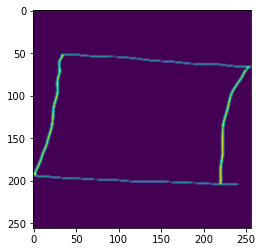

In [47]:
plt.imshow(dataset[25][0].squeeze())

In [48]:
model(dataset[25][0].unsqueeze(0))

tensor([[1.6299e-09, 1.0000e+00, 9.8936e-09, 4.7068e-08, 9.8954e-14]],
       grad_fn=<SoftmaxBackward>)

In [49]:
img = cv2.imread("drawings/L_TOP/L_right-18.jpeg", 0)
img = preprocess(img)
img = img_transform(img)
img

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

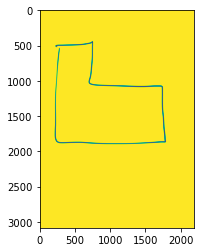

In [3]:
img = cv2.imread("drawings/L_TOP/L_right-18.jpeg", 1)
plt.imshow(img)

In [5]:
img

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)